In [ ]:
!pip install keras_tuner

import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt

import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import json

#Image Classification using Neural Networks on Fashion MNIST

author: [Bruno Velleca](https://github.com/brucamail)

## Motivation
###Overview
Image classification is a fundamental problem in computer vision with significant real-world applications. The ability to automatically identify and categorize objects within images has revolutionized various industries. For example, in retail, image classification is used for automatic classification of goods, improving inventory management. In healthcare, it aids in classifying potential skin diseases. Manufacturing benefits from it for inspecting products on assembly lines for defects.

This technology not only automates tasks but also opens doors to new possibilities in areas like autonomous vehicles, security surveillance, and content moderation, making it a critical area of research and development.

### Purpose
While numerous models already achieve high accuracy on this dataset, my primary goal is to leverage this well-established benchmark as a learning opportunity and deepen my practical knowledge of CNN architectures.

Leveraging such a well establihsed dataset allows me to experiment with various hyperparameters, such as batch size, activation functions, learning rate, and dropout, to observe their impact on model performance and gain insights into the fine-tuning process of buidling a CNN.

### The Data
Fashion-MNIST is a dataset of [Zalando's](https://www.zalando.com/) article images it consists of a training set of 60,000 observations and a test set of 10,000 observations categorized in 10 classes. It was published to be a replacement to the original MNIST dataset used for benchmarking machine learning algorithms.

Each observation is a 28x28 grayscale image, associated with a numeric label from 0 to 9 according to the following mapping:

0. 'T-shirt/top',
1. 'Trouser',
2. 'Pullover',
3. 'Dress',
4. 'Coat',
5. 'Sandal',
6. 'Shirt',
7. 'Sneaker',
8. 'Bag',
9. 'Ankle boot'

The data will be directly sourced from Keras datasets.

**Thorughout the notebook I'll leverage ideas from papers and other notebooks, providing the links to their work for further reference.**

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


## Explorary Data Analysis

### Data Distribution
Let's first take a look if all the classes are evenly distributed in the dataset:

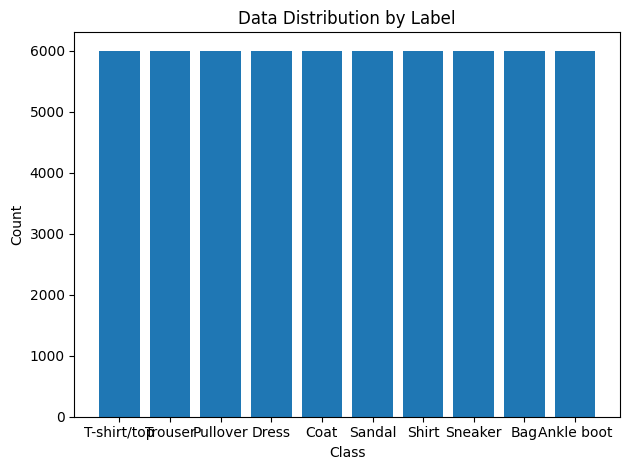

T-shirt/top: 6000
Trouser: 6000
Pullover: 6000
Dress: 6000
Coat: 6000
Sandal: 6000
Shirt: 6000
Sneaker: 6000
Bag: 6000
Ankle boot: 6000


In [ ]:
### checking the data distribution by label and plotting a histogram chart
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'];
unique, counts = np.unique(y_train, return_counts=True)

plt.bar(unique, counts)
plt.xticks(unique, class_names)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Data Distribution by Label')
plt.tight_layout()
plt.show()

#printing count numbers by label
for i in range(10):
  print(f'{class_names[i]}: {counts[i]}')


As we can see the dataset is evenly distributed across the 10 classes, with 10% of the observations (6000) for each class.

### Data Visualization
Let's now take a look at the images by class:

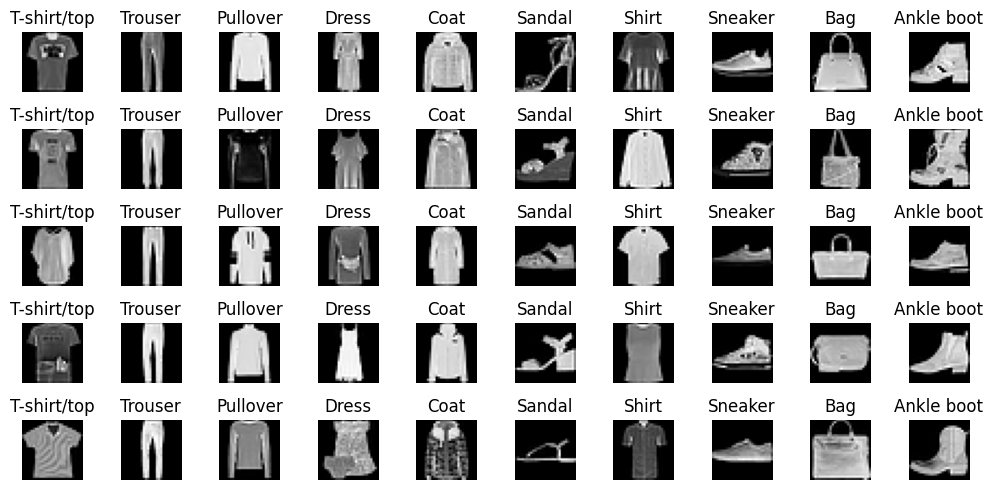

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'];

# getting 5 random samples per class
samples = []
for r in range(5):
  row = []
  for i in range(10):
    #getting the ids of images according to their class
    row.append(np.random.choice(np.where(y_train == i)[0]))
  samples.append(row)

#plotting the samples
fig, axs = plt.subplots(5, 10, figsize=(10, 5))
for i in range(5):
  for j in range(10):
    axs[i, j].imshow(x_train[samples[i][j]], cmap='gray')
    axs[i, j].set_title(class_names[y_train[samples[i][j]]])
    axs[i, j].axis('off')

plt.tight_layout()
plt.show()

 In the current format, as imported from Keras, the images are 2 dimensional arrays. All the images are 28 by 28 pixels in grey scale. Depending on the data source, you might get 1D array with 784 pixels.

 An important thing to notice is that all items are vertically displayed and centered in the image. This could cause the model to overfit and become incapable of categorizing images outside of this dataset, making image preprocessing an important step for our model.


**Note**: Because the test dataset is also vertically oriented and the items are centered in the image, there is a likelyhood that image preprocessing in this case might decrease our accuracy in testing, but still should make our model more capable of generalizing the categories.

### Data Augmentation
While it is common sense among Data Scientists that augmenting the data will always improve the model outputs, we want to check this hypothesis here. To do so we will:
1. Generate a data sample `x_train_sample` containing 20% of the original training dataset without any augmentation techniques
2. Build a basic CNN model (based on [Keras tutorial](https://keras.io/examples/vision/mnist_convnet/))
4. Train the `sample_model` where no augmentation technique is used and train the `aug_model` where augmentation techniques are used.
5. Compare performance between both models against the test data.

**Note:** I've opted to apply the image preprocessing/data augmentation as part of the model as seen in the code instead of applying them to the dataset directly. By doing so the Data augmentation will run on-device, synchronously with the rest of the layers, and benefit from GPU acceleration.

When exporting the model using model.save, **the preprocessing layers will be saved along with it automatically standardizing images** (according to the configuration of the layers) saving me from having to preprocess images in the future.

All parameters will be the same for both models, the only change will be the augmented layers.


The following data augmentation techniques will be applied:
* `RandomFlip`: randomly flip images horizontally and vertically
* `RandomRotation`: randomly rotate images according to a maximum factor

```
model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(factor = 1/4))
```

Additionally, we'll use `Rescalling` for all our models, changing the scale of the pixels from (0,255) to (0,1) helping model time performance.

In [ ]:
#generating the sample data
num_classes = 10

x_train_sample = x_train[:int(0.2*len(x_train))]
y_train_sample = y_train[:int(0.2*len(y_train))]

#transforming y_train to fit the model output
y_train_sample_one_hot = keras.utils.to_categorical(y_train_sample, num_classes=num_classes)


In [ ]:
def plot_history(hist):
    '''
    source:https://www.kaggle.com/code/shawkyelgendy/data-augmentation-guide
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (15, 6))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


#### Base Model
This is a basic model with a Input layer, a hidden layer and a output layer:
* Input layer: the size of the input images and Rescalling
* Dense Layer with 128 neurons and `relu` activation function
* Output Dense Layer with 10 neurons and `softmax` activation function

The output layer has to be 10 neurons with a softmax to allow for the network to calculate the probability of a input to belong to each class.

In [ ]:
input_shape = (28, 28, 1)

def base_model(data_aug = False, dropout = False):
  model = keras.Sequential(
      [   keras.Input(shape=input_shape),
          layers.Rescaling(1./255)
      ])
  if data_aug: #applies data augmentation if True
    model.add(layers.RandomFlip("horizontal_and_vertical"))
    model.add(layers.RandomRotation(factor=1/16)) #up to 22.5 degres

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))

  if dropout: #applies dropout if True
    model.add(layers.Dropout(0.5))

  model.add(layers.Dense(10, activation='softmax'))

  return model

In [ ]:
#training the sample model
batch_size = 32
epochs = 30

sample_model = base_model(data_aug=False)
sample_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_sample = sample_model.fit(x_train_sample, y_train_sample_one_hot, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6981 - loss: 0.9001 - val_accuracy: 0.8225 - val_loss: 0.5369
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8242 - loss: 0.5051 - val_accuracy: 0.8283 - val_loss: 0.4959
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8528 - loss: 0.4187 - val_accuracy: 0.8500 - val_loss: 0.4520
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8586 - loss: 0.3971 - val_accuracy: 0.8450 - val_loss: 0.4445
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8738 - loss: 0.3579 - val_accuracy: 0.8625 - val_loss: 0.4000
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8744 - loss: 0.3513 - val_accuracy: 0.8633 - val_loss: 0.3816
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8804 - loss: 0.3347 - val_accuracy: 0.8483 - val_loss: 0.4179
Epoch 8/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8944 - loss: 0.3017 - val_accuracy: 0.

In [ ]:
#training augmented model
batch_size = 32
epochs = 30

aug_model = base_model(data_aug=True)
aug_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_aug = aug_model.fit(x_train_sample, y_train_sample_one_hot, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5495 - loss: 1.2732 - val_accuracy: 0.7117 - val_loss: 0.7796
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7006 - loss: 0.8066 - val_accuracy: 0.7433 - val_loss: 0.6877
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7372 - loss: 0.7081 - val_accuracy: 0.7492 - val_loss: 0.6669
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7616 - loss: 0.6442 - val_accuracy: 0.7508 - val_loss: 0.6700
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7620 - loss: 0.6323 - val_accuracy: 0.7633 - val_loss: 0.6341
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7733 - loss: 0.6140 - val_accuracy: 0.7750 - val_loss: 0.6174
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7883 - loss: 0.5786 - val_accuracy: 0.7692 - val_loss: 0.6117
Epoch 8/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7961 - loss: 0.5533 - val_accuracy: 0.

#### Comparison 1: Augmented Data

Sample model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8536 - loss: 0.5929
Test accuracy: 0.8479999899864197 Test loss: 0.6113682389259338



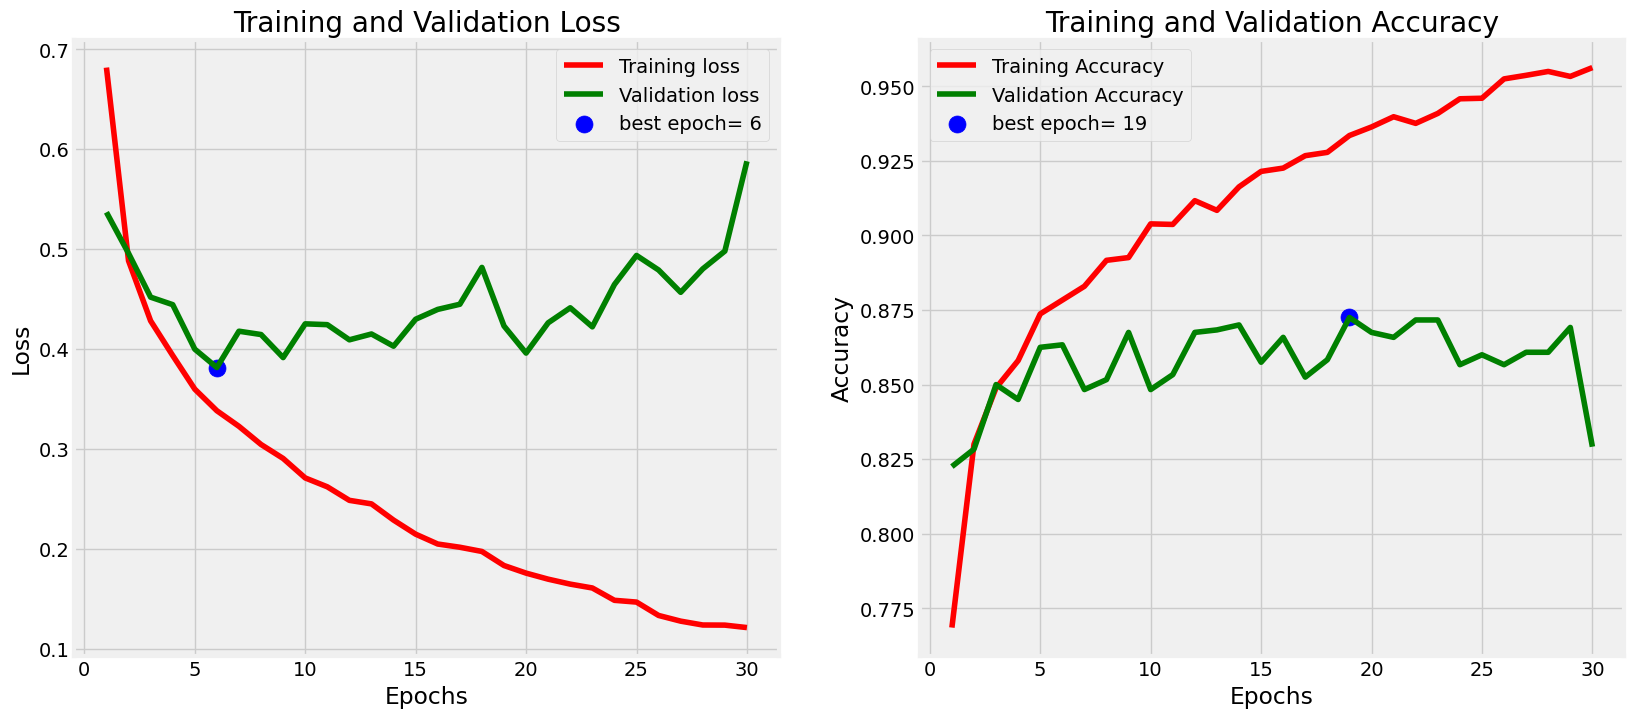


Augmented model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8180 - loss: 0.5151
Test accuracy: 0.8165000081062317 Test loss: 0.519512414932251



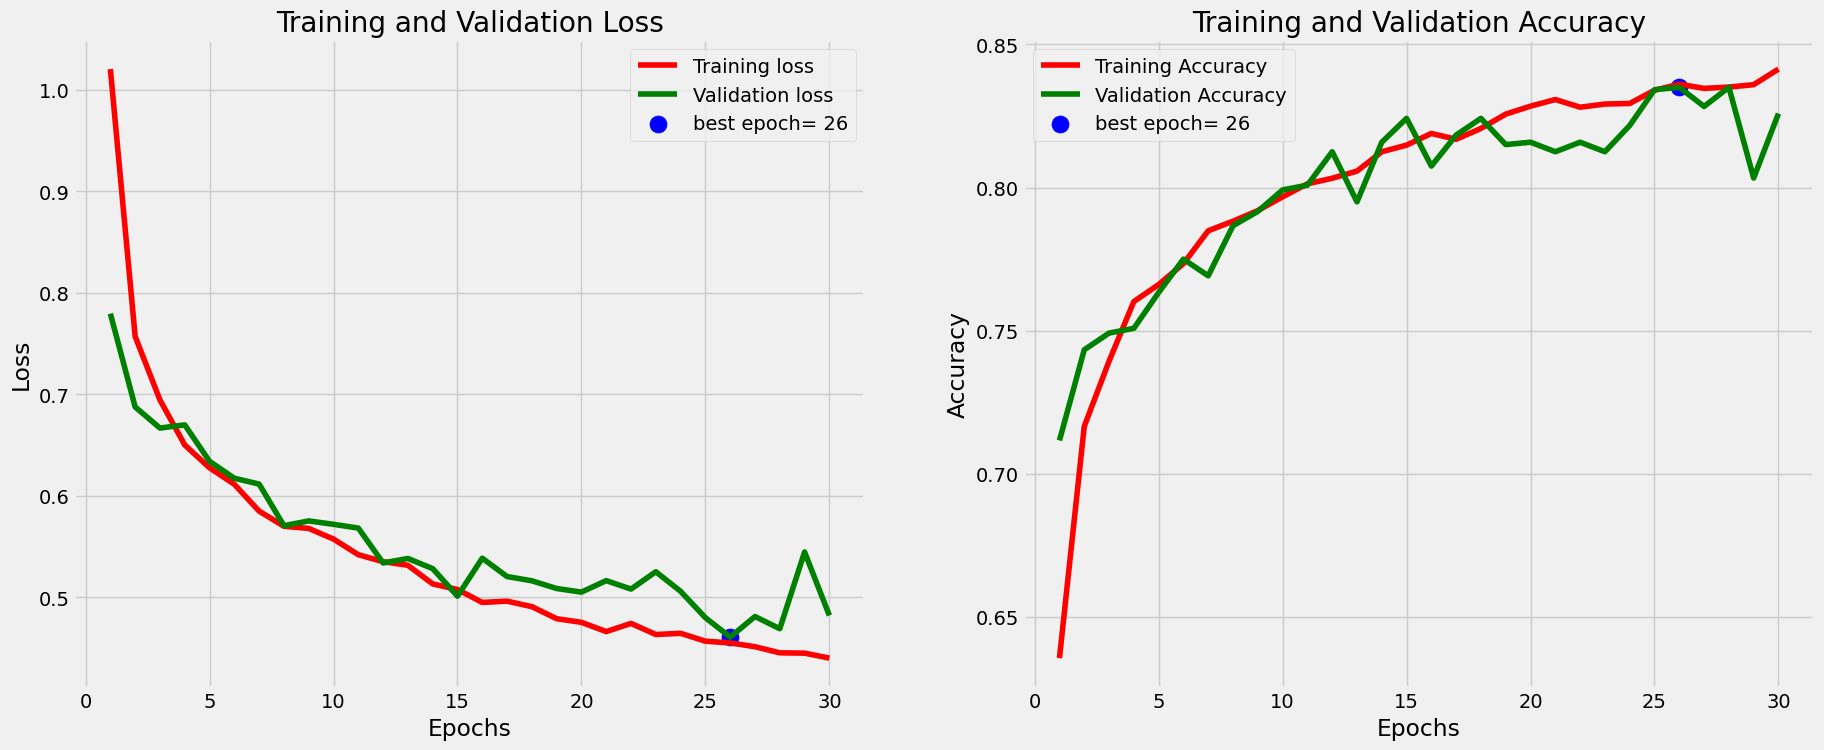

In [ ]:
print("Sample model:")
eval = sample_model.evaluate(x_test, keras.utils.to_categorical(y_test, num_classes=num_classes))
print (f'Test accuracy: {eval[1]}', f'Test loss: {eval[0]}\n')
plot_history(history_sample)

print("\nAugmented model:")
eval = aug_model.evaluate(x_test, keras.utils.to_categorical(y_test, num_classes=num_classes))
print (f'Test accuracy: {eval[1]}', f'Test loss: {eval[0]}\n')
plot_history(history_aug)

By looking at test accuracy of both models, one might initially think that data augmentation might be detrimental to our model, but when looking at the charts more closely, it is possible no notice that the `sample_model` starts overfitting around epoch 10, with the validation loss trending up while the training loss decreases steadly.

The `aug_model` on the other hand keeps treding down even after 30 epochs, indicating that with further training we might be able to improve the outcome with less overfitting. **Therefore for future models we will use data augmentation methods**.

## Model Architecture
The base model with data augmentation was able to achieve 81% accuracy on the test data after only 30 epochs and being trained on 20% of the data. It is a pretty impressive achievement for a model with 1 hidden layer with a randomly selected number of neurons and nothing else.

We'll use it as a reference and will try different techniques and parameters to see if we are able to create a more thoughtful architecture that will allow us to increase our test accuracy and reduce overfitting.

### Dropout
When looking at the charts from both models above, we see a lot of variance in the accuracy and loss for the validation dataset. This is yet another sign of overfitting. We believe we can smooth it out by adding a dropout before the output layer:

In [ ]:
#augmented model with dropout
batch_size = 32
epochs = 30

aug_drop_model = base_model(data_aug=True, dropout=True)
aug_drop_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_aug_drop = aug_drop_model.fit(x_train_sample, y_train_sample_one_hot, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4237 - loss: 1.5722 - val_accuracy: 0.6933 - val_loss: 0.8499
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6281 - loss: 0.9948 - val_accuracy: 0.7117 - val_loss: 0.7486
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6706 - loss: 0.8793 - val_accuracy: 0.7183 - val_loss: 0.7034
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6884 - loss: 0.8250 - val_accuracy: 0.7408 - val_loss: 0.6824
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6978 - loss: 0.8115 - val_accuracy: 0.7642 - val_loss: 0.6454
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7035 - loss: 0.7730 - val_accuracy: 0.7592 - val_loss: 0.6376
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7114 - loss: 0.7643 - val_accuracy: 0.7708 - val_loss: 0.6309
Epoch 8/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7232 - loss: 0.7302 - val_accuracy: 0.

#### Comparison 2: Dropout


Augmented model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8180 - loss: 0.5151
Test accuracy: 0.8165000081062317 Test loss: 0.519512414932251



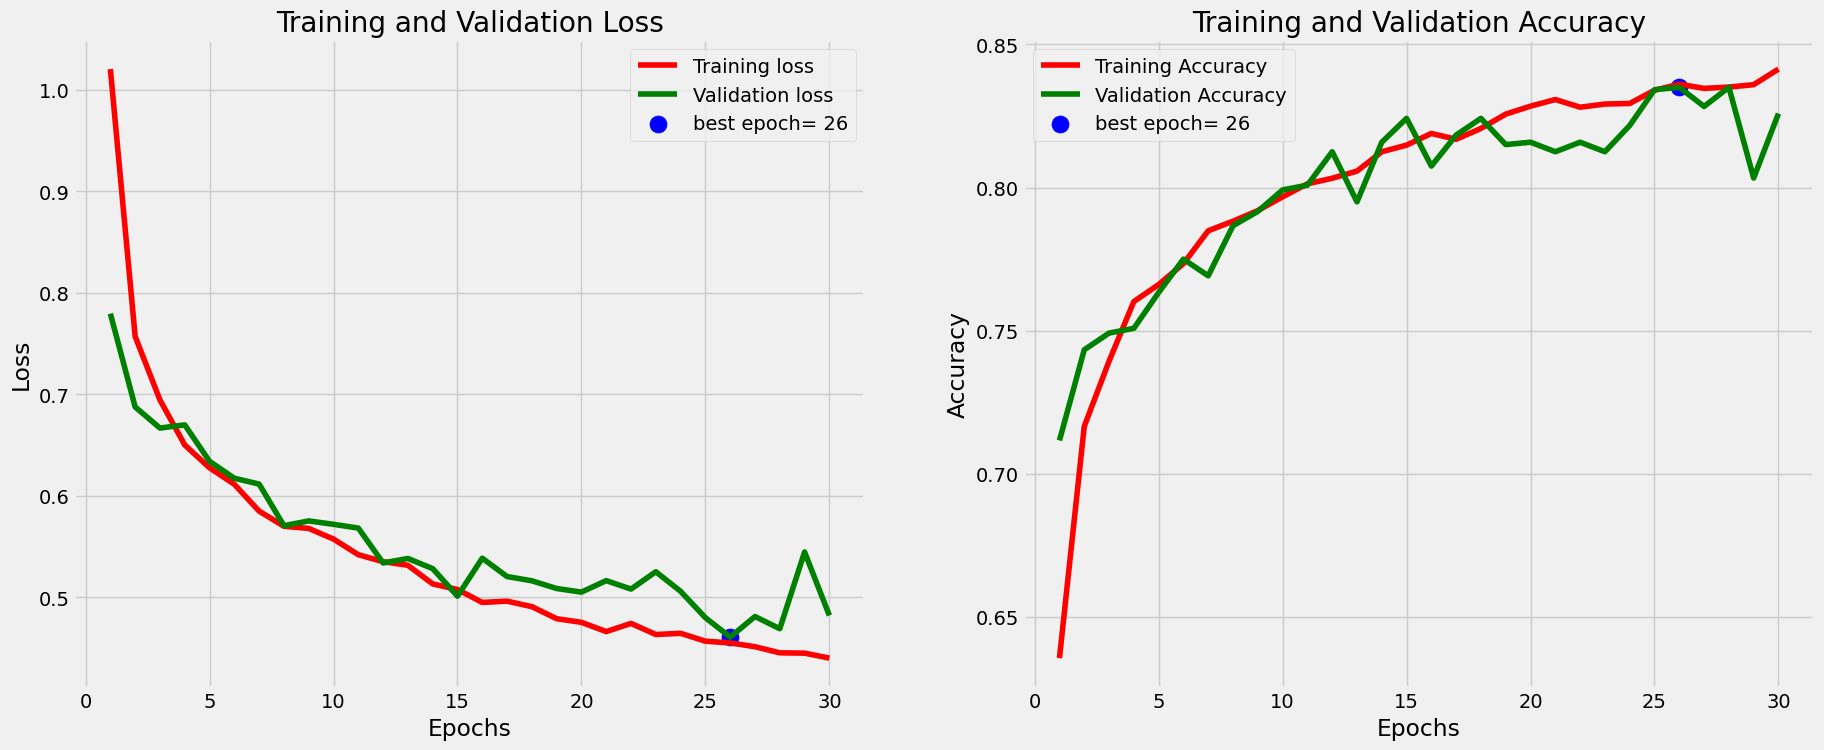


Augmented model with Dropout:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7968 - loss: 0.5650
Test accuracy: 0.7954999804496765 Test loss: 0.5634591579437256



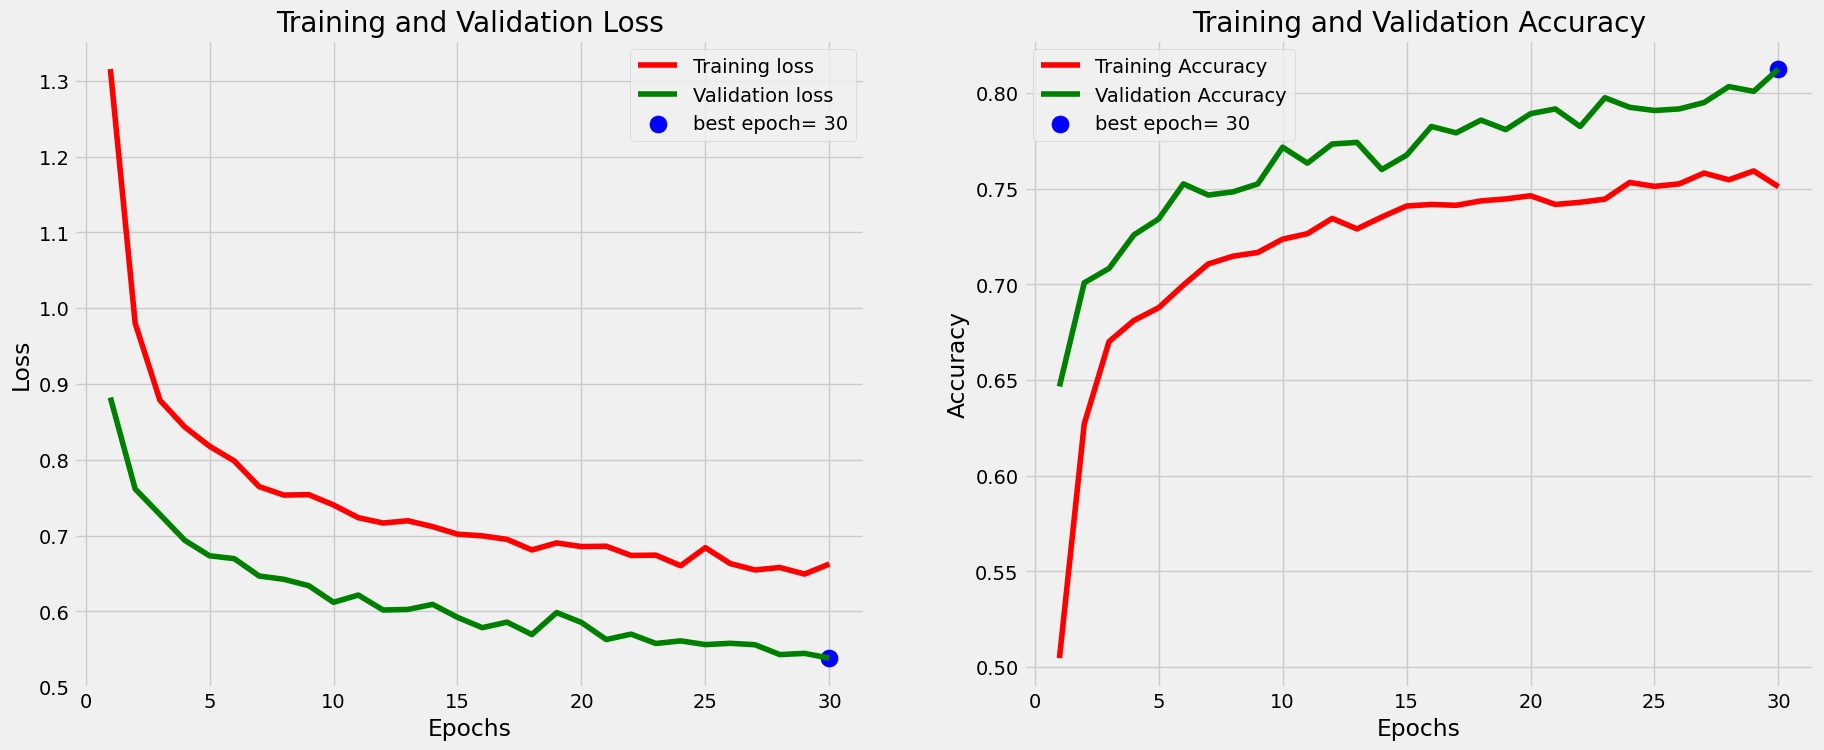

In [ ]:
print("\nAugmented model:")
eval = aug_model.evaluate(x_test, keras.utils.to_categorical(y_test, num_classes=num_classes))
print (f'Test accuracy: {eval[1]}', f'Test loss: {eval[0]}\n')
plot_history(history_aug)

print("\nAugmented model with Dropout:")
eval = aug_drop_model.evaluate(x_test, keras.utils.to_categorical(y_test, num_classes=num_classes))
print (f'Test accuracy: {eval[1]}', f'Test loss: {eval[0]}\n')
plot_history(history_aug_drop)

There's a clear improvement on the variation of the validation dataset, indicating we are reducing the overfitting. But our accuracy dropped once again to 79.5% on the validation set. The natural next step would be to add BatchNormalization, but since we have only 1 hidden layer, it didn't prove to be as effective.

Notice here that the loss and accuracy of the model with dropout are  stabilizing, so even with further epochs, we won't improve the accuracy significantly.

**To further improve this model we need a more drastic change to it's architecture, like changing the number of neurons or adding more and different types of layers.**

### Adding Convolutional Layers
A convolutional layer allows us to extract features from an input (like an image) by applying a filter (kernel) across it. This filter learns to detect specific patterns, such as edges, textures, or shapes.

Every convolutional layer will have:
* `kernel_size = (3,3)` : The kernel detects image features like shapes and edges. Using 3x3 according to recommendation in class.
* `padding = 'Same'` : As we apply convolutions, the output will decrease faster than wanted. So in the early layers of our network, I decided to preserve as much information as possible about the original input.
* `activation = 'relu'`: Using relu as the activation function breaks the linearity from the convolution

In addition to the convolutional layers, we'll apply:

* `BatchNormalization`: Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1. - It should help to stabilize training, reduce overfitting, and converge faster
* `MaxPooling2D`: Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window. It enhances translation invariance and reduces dimensionality, contributing to better precision even when pixel patterns are similar

```
model.add(layers.Conv2D(layer, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(keras.layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
```

The goal is to use Convolutional Layers as an input to then train our fully connected layers. Instead of modifying the original base model, the function `convo_base_model` below has been created for testing.

In [ ]:
input_shape = (28, 28, 1)

#base model with convolutional layers - the args allow for multiple layers.
def convo_base_model(convo_layer_sizes = [128], dense_layer_sizes = [128]):
  model = keras.Sequential(
      [   keras.Input(shape=input_shape),
          layers.Rescaling(1./255)
      ])
  model.add(layers.RandomFlip('horizontal_and_vertical'))
  model.add(layers.RandomRotation(factor=1/16)) #up to 22.5 degres

  #multiple convo layers if needed
  for layer in convo_layer_sizes:
    model.add(layers.Conv2D(layer, kernel_size=(3, 3), activation='relu', padding = 'same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(keras.layers.BatchNormalization())
  model.add(layers.Flatten())

  #base model with droput & multiple dense layers if needed
  for layer in dense_layer_sizes:
    model.add(layers.Dense(layer, activation='relu'))
    model.add(layers.Dropout(0.5))

  model.add(layers.Dense(10, activation='softmax'))

  return model

In [ ]:
#building a model with 1 convolution and 1 dense layer
batch_size = 32
epochs = 30

convo_sample_model = convo_base_model()
convo_sample_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_convo = convo_sample_model.fit(x_train_sample, y_train_sample_one_hot, batch_size=batch_size, epochs=epochs, validation_split=0.1)

In [ ]:
#buidling a model with 2 layers on convolution and 2 dense layer
batch_size = 32
epochs = 30

convo_2_layers = convo_base_model([128, 64],[256,128])
convo_2_layers.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_convo_2 = convo_2_layers.fit(x_train_sample, y_train_sample_one_hot, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.2527 - loss: 2.4327 - val_accuracy: 0.1308 - val_loss: 7.1025
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4205 - loss: 1.5479 - val_accuracy: 0.5167 - val_loss: 1.2316
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5116 - loss: 1.2923 - val_accuracy: 0.6183 - val_loss: 1.0186
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5386 - loss: 1.1923 - val_accuracy: 0.6225 - val_loss: 0.9590
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5756 - loss: 1.1224 - val_accuracy: 0.6217 - val_loss: 0.9161
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5976 - loss: 1.0543 - val_accuracy: 0.6608 - val_loss: 0.9420
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6232 - loss: 1.0015 - val_accuracy: 0.5675 - val_loss: 1.2326
Epoch 8/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6301 - loss: 0.9724 - val_accu

#### Comparison 3: Convolutional Layers


Augmented model with Dropout:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7968 - loss: 0.5650
Test accuracy: 0.7954999804496765 Test loss: 0.5634591579437256



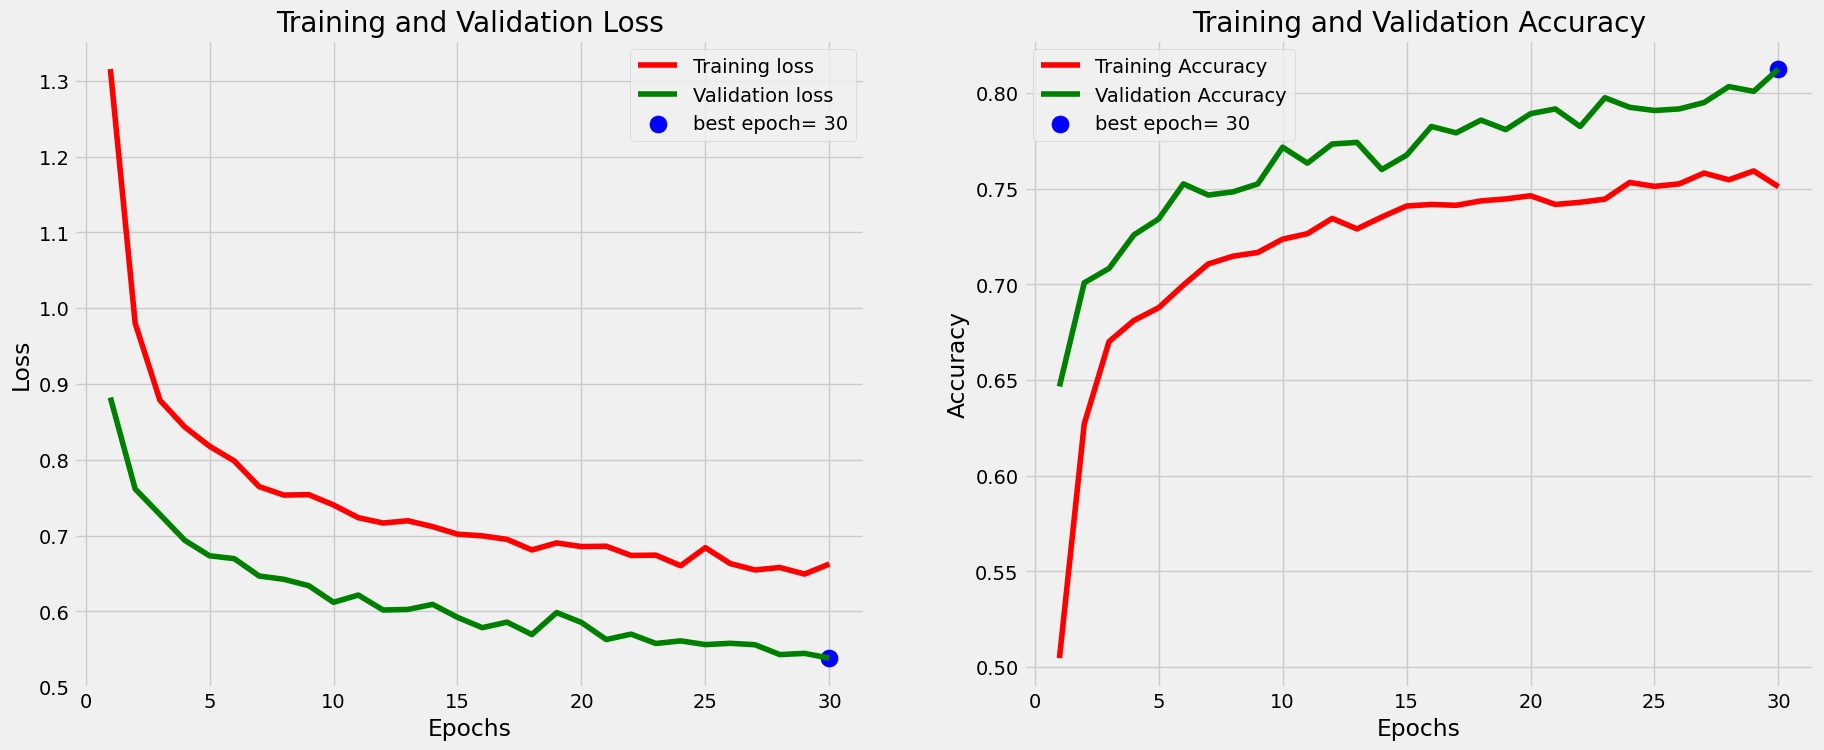


Convolutional model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7863 - loss: 0.6396
Test accuracy: 0.7846999764442444 Test loss: 0.6400010585784912



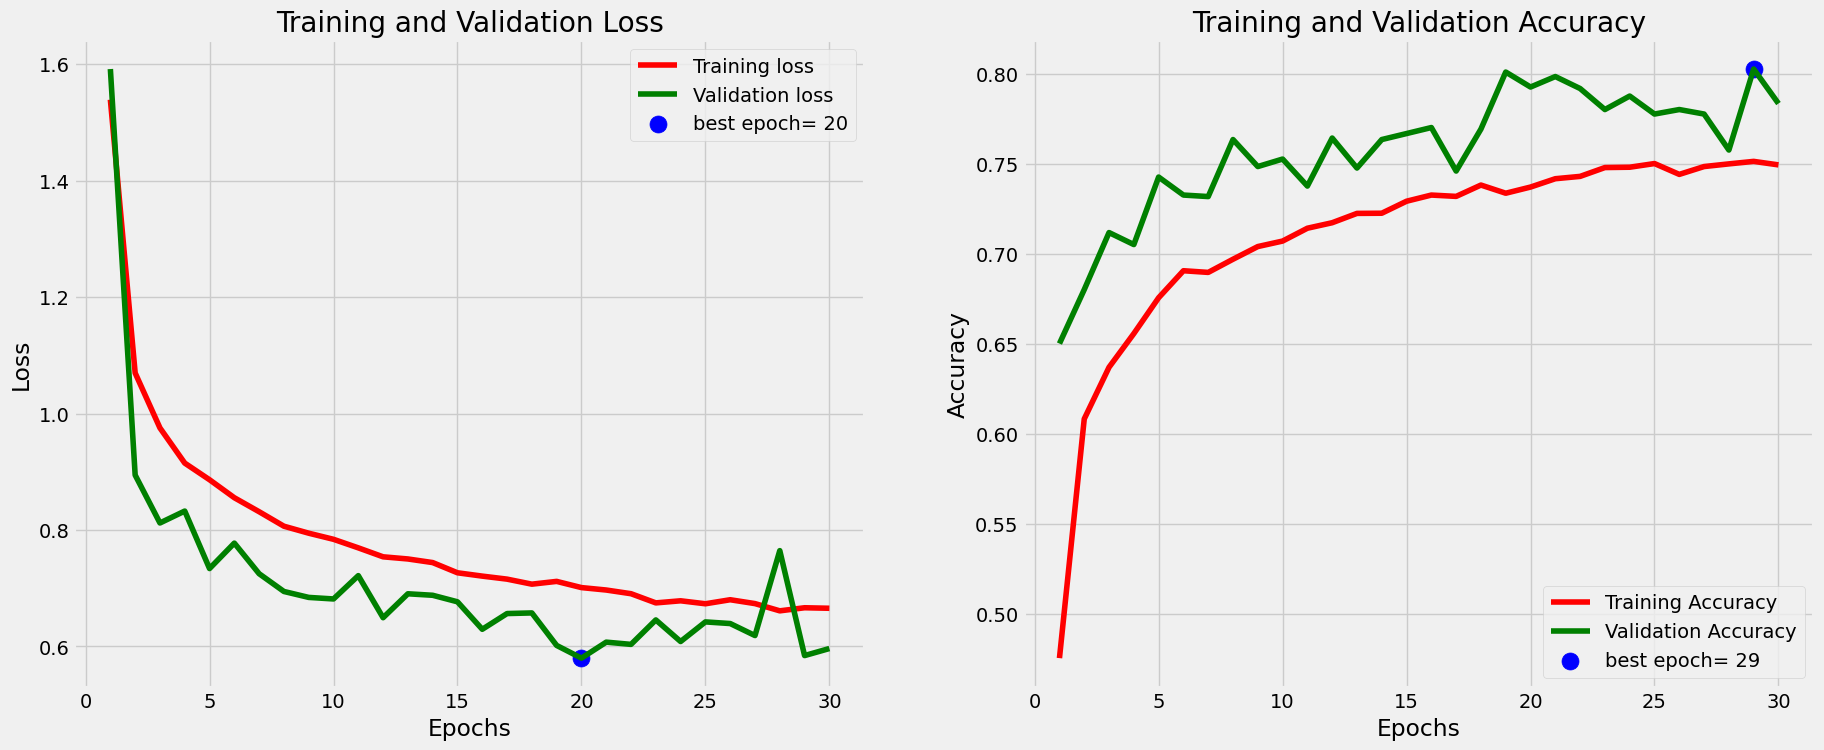


Convolutional model with 2 layers:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7705 - loss: 0.6748
Test accuracy: 0.7677000164985657 Test loss: 0.6582040190696716



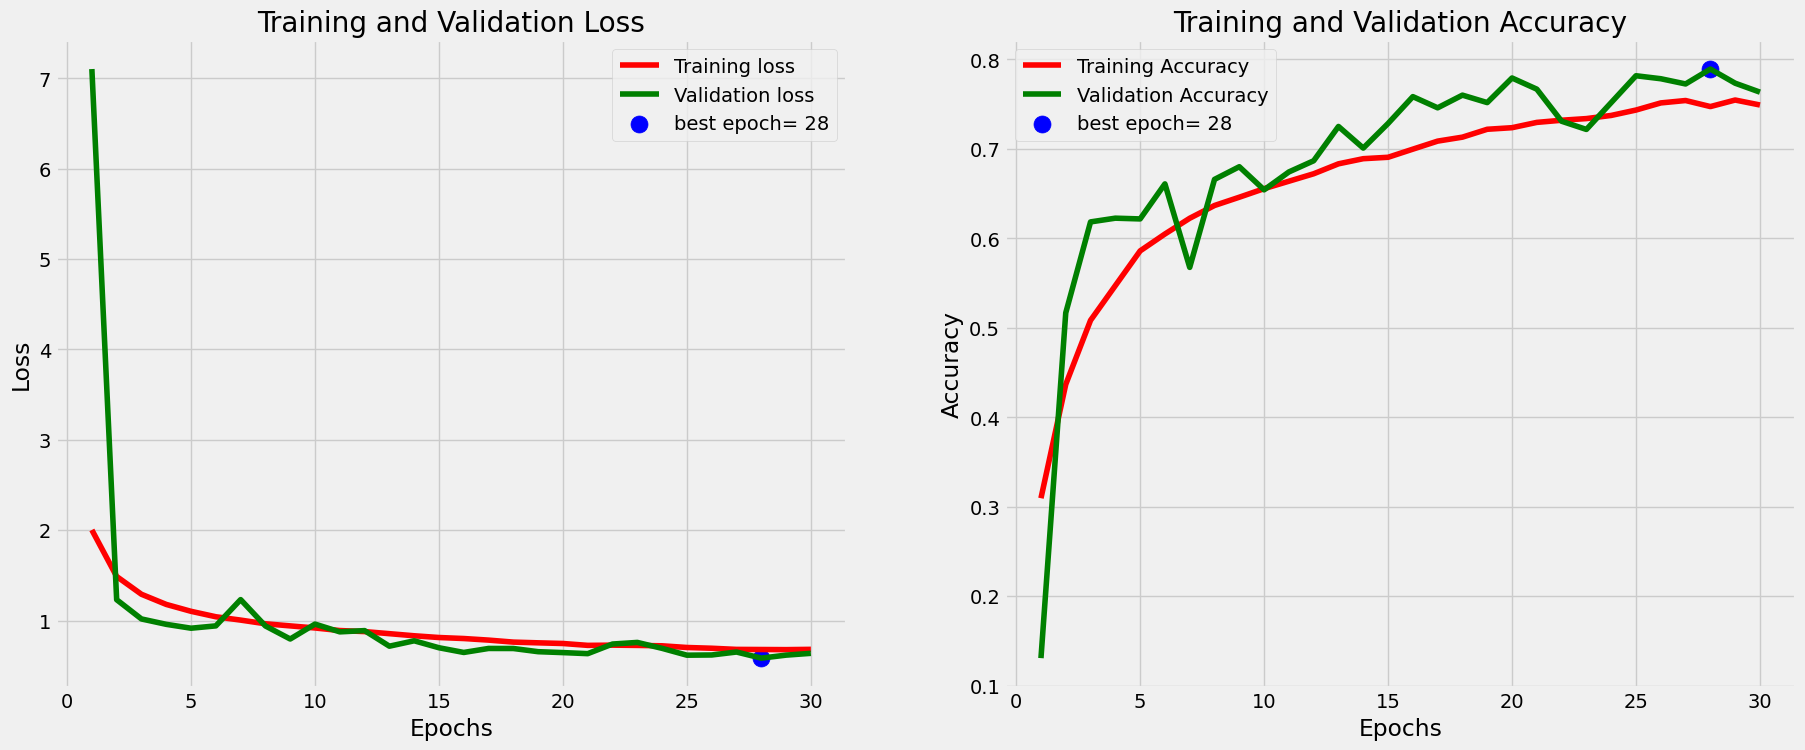

In [ ]:
print("\nAugmented model with Dropout:")
eval = aug_drop_model.evaluate(x_test, keras.utils.to_categorical(y_test, num_classes=num_classes))
print (f'Test accuracy: {eval[1]}', f'Test loss: {eval[0]}\n')
plot_history(history_aug_drop)

print("\nConvolutional model:")
eval = convo_sample_model.evaluate(x_test, keras.utils.to_categorical(y_test, num_classes=num_classes))
print (f'Test accuracy: {eval[1]}', f'Test loss: {eval[0]}\n')
plot_history(history_convo)

print("\nConvolutional model with 2 layers:")
eval = convo_2_layers.evaluate(x_test, keras.utils.to_categorical(y_test, num_classes=num_classes))
print (f'Test accuracy: {eval[1]}', f'Test loss: {eval[0]}\n')
plot_history(history_convo_2)

Adding Convolutional Layers didn't seem to improve the outcome of the model. In both cases accuracy dropped. With 1 convo layer it dropped to 78% and with 2 convo layers together with 2 dense layers, dropped even further to 77%.  What is most concerning is the variance that both models introduced on validatation and accucary measurements. In order to futher compare the models, we need beter hyperparameters, so we'll try kera-tuner to refine the **Convolutional Model with 2 layers**.

## HyperParameter Tuning
There are several hyperparameters to tune and refine, for this exercise, we'll leverage [keras-tuner](https://keras.io/keras_tuner/getting_started/) and will try the following hyperparameters:
* `batchsize`: [32, 64, 128]
* `convolution layers`: number of convolutional layers
* `filters`: How many units per hidden convo layer in the model

* `dense layers`: number of dense layers
* `units`: How many units per hidden dense layer in the model

* `batchNormalization`: When is it needed?
* `Dropout`: When is it needed?

* `learning rate`: From 0.0001 to 0.001

For the number of epochs, we'll define a max of 30 eposh and use Keras `EarlyStopping` with a low tolerance of 3: `
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) `


In [ ]:
input_shape = (28, 28, 1)
#function to build and hypertune the model
def hypertuned_model(hp):
  model = keras.Sequential(
        [   keras.Input(shape=input_shape),
            layers.Rescaling(1./255)
        ])
  model.add(layers.RandomFlip('horizontal_and_vertical'))
  model.add(layers.RandomRotation(factor=1/16)) #up to 22.5 degres

  for i in range(hp.Int("num_convo_layers", 1, 3)): # deciding how many convolutional layesr to use
      model.add(layers.Conv2D(
          filters = hp.Int(f"units_{i}", min_value=16, max_value=256, step=16), # how many units per layer
          kernel_size=(3, 3), activation='relu', padding = 'same'))
      model.add(layers.MaxPooling2D(pool_size=(2, 2)))
      if hp.Boolean(f"batchnorm_{i}"): # deciding if batch normalization is needed
        model.add(keras.layers.BatchNormalization())

  model.add(layers.Flatten())

  for i in range(hp.Int("num_dense_layers", 1, 3)): # deciding how many dense layers to use
    model.add(layers.Dense(
        units=hp.Int(f"dense_units_{i}", min_value=16, max_value=256, step=16),
        activation='relu'))

    if hp.Boolean(f"dropout_{i}"): # deciding if dropout is needed
      model.add(layers.Dropout(0.5))

  model.add(layers.Dense(10, activation='softmax'))

  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])

  return model

In [ ]:
tuners = {} # Dictionary to store tuners for each batch size
# batch_sizes = [32, 64, 128]

def tune_model(batch_size):
  # Implementing Keras earlyStopping to help decide the best number of epochs
  callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
  print(f"Fitting tuner with batch size: {batch_size}")
  tuner_name = f'hypertuned_model_{batch_size}'

  tuner = kt.RandomSearch(
      hypermodel=hypertuned_model,
      objective='val_loss',
      max_trials=10,
      # directory='my_dir',
      project_name=tuner_name,
      executions_per_trial=3
  )
  tuner.search(x_train_sample, y_train_sample_one_hot, epochs=30, validation_split=0.1, callbacks=[callback], batch_size=batch_size)
  tuners[batch_size] = tuner
  return tuner

#### Batch size: 32

In [ ]:
tuner32 = tune_model(32)

Trial 10 Complete [00h 02m 57s]
val_loss: 0.5489548444747925

Best val_loss So Far: 0.343469500541687
Total elapsed time: 00h 28m 52s


In [ ]:
#getting the best params from the model
best_hp_32 = tuner32.get_best_hyperparameters()[0]
best_32 = json.dumps(best_hp_32.values, indent=4)
print(best_32)

{
    "num_convo_layers": 3,
    "units_0": 160,
    "batchnorm_0": false,
    "num_dense_layers": 1,
    "dense_units_0": 48,
    "dropout_0": false,
    "lr": 0.0005664500123580879,
    "units_1": 112,
    "batchnorm_1": true,
    "dense_units_1": 32,
    "dropout_1": false,
    "units_2": 96,
    "batchnorm_2": true,
    "dense_units_2": 48,
    "dropout_2": true
}


#### Batch size: 64

In [ ]:
# batch_sizes = [64]
tuner64 = tune_model(64)

Trial 10 Complete [00h 01m 43s]
val_loss: 0.38030250867207843

Best val_loss So Far: 0.3534712890783946
Total elapsed time: 00h 22m 41s


In [ ]:
best_hp_64 = tuner64.get_best_hyperparameters()[0]
best_64 = json.dumps(best_hp_64.values, indent=4)
print(best_64)

{
    "num_convo_layers": 2,
    "units_0": 240,
    "batchnorm_0": true,
    "num_dense_layers": 3,
    "dense_units_0": 96,
    "dropout_0": false,
    "lr": 0.0003609237611847573,
    "units_1": 208,
    "batchnorm_1": true,
    "dense_units_1": 192,
    "dropout_1": false,
    "units_2": 112,
    "batchnorm_2": true,
    "dense_units_2": 176,
    "dropout_2": true
}


#### Batch size: 128

In [ ]:
# batch_sizes = [128]
tuner128 = tune_model(128)

Trial 10 Complete [00h 03m 06s]
val_loss: 0.39392651120821637

Best val_loss So Far: 0.3543291389942169
Total elapsed time: 00h 17m 10s


In [ ]:
best_hp_128 = tuner128.get_best_hyperparameters()[0]
best_128 = json.dumps(best_hp_128.values, indent=4)
print(best_64)

{
    "num_convo_layers": 2,
    "units_0": 240,
    "batchnorm_0": true,
    "num_dense_layers": 3,
    "dense_units_0": 96,
    "dropout_0": false,
    "lr": 0.0003609237611847573,
    "units_1": 208,
    "batchnorm_1": true,
    "dense_units_1": 192,
    "dropout_1": false,
    "units_2": 112,
    "batchnorm_2": true,
    "dense_units_2": 176,
    "dropout_2": true
}


## Best Model
The model with lowest validation loss was also the simplest model:

The model has 3 convolutional layers and 1 dense layer with a bacth size of 32.

The remaining hyperparameter choices are displayed in the json format
below as well as in the printed summary:
```
{
    "num_convo_layers": 3,
    "units_0": 160,
    "batchnorm_0": false,
    "num_dense_layers": 1,
    "dense_units_0": 48,
    "dropout_0": false,
    "lr": 0.0005664500123580879,
    "units_1": 112,
    "batchnorm_1": true,
    "dense_units_1": 32,
    "dropout_1": false,
    "units_2": 96,
    "batchnorm_2": true,
    "dense_units_2": 48,
    "dropout_2": true
}
```

We'll go ahead and use these parameters to train a new model called `best_model. We'll also plot it's training and validation loss and accuracy curves.

For the final training we'll increase the max number of epochs and use the callback function with a higher tolerance (6) than used for hyperparameter search.

In [ ]:
best_model_32 = tuner32.get_best_models()[0]
best_model_32.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 28, 28, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 160)    │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 112)    │       161,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 112)      │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 96)       │        96,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │        41,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302,698 (1.15 MB)

 Trainable params: 302,282 (1.15 MB)

 Non-trainable params: 416 (1.62 KB)

In [ ]:
# Get the best hyperparameters
best_hp = tuner32.get_best_hyperparameters()[0]
# Build a new model with the best hyperparameters
best_model = tuner32.hypermodel.build(best_hp)

#callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
best_hist = best_model.fit(x_train_sample, y_train_sample_one_hot, epochs=90, validation_split=0.1, callbacks=[callback])

Epoch 1/90
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6305 - loss: 1.0269 - val_accuracy: 0.3925 - val_loss: 1.8607
Epoch 2/90
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7803 - loss: 0.5789 - val_accuracy: 0.7908 - val_loss: 0.5662
Epoch 3/90
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8144 - loss: 0.5135 - val_accuracy: 0.7942 - val_loss: 0.5660
Epoch 4/90
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8232 - loss: 0.4704 - val_accuracy: 0.8375 - val_loss: 0.4247
Epoch 5/90
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8461 - loss: 0.4097 - val_accuracy: 0.8292 - val_loss: 0.4956
Epoch 6/90
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8476 - loss: 0.4149 - val_accuracy: 0.8250 - val_loss: 0.4948
Epoch 7/90
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8537 - loss: 0.3891 - val_accuracy: 0.8492 - val_loss: 0.4144
Epoch 8/90
338/338 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8626 - loss: 0.3781 - val_accura

Best model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8698 - loss: 0.4233
Test accuracy: 0.8712000250816345 Test loss: 0.4096207618713379



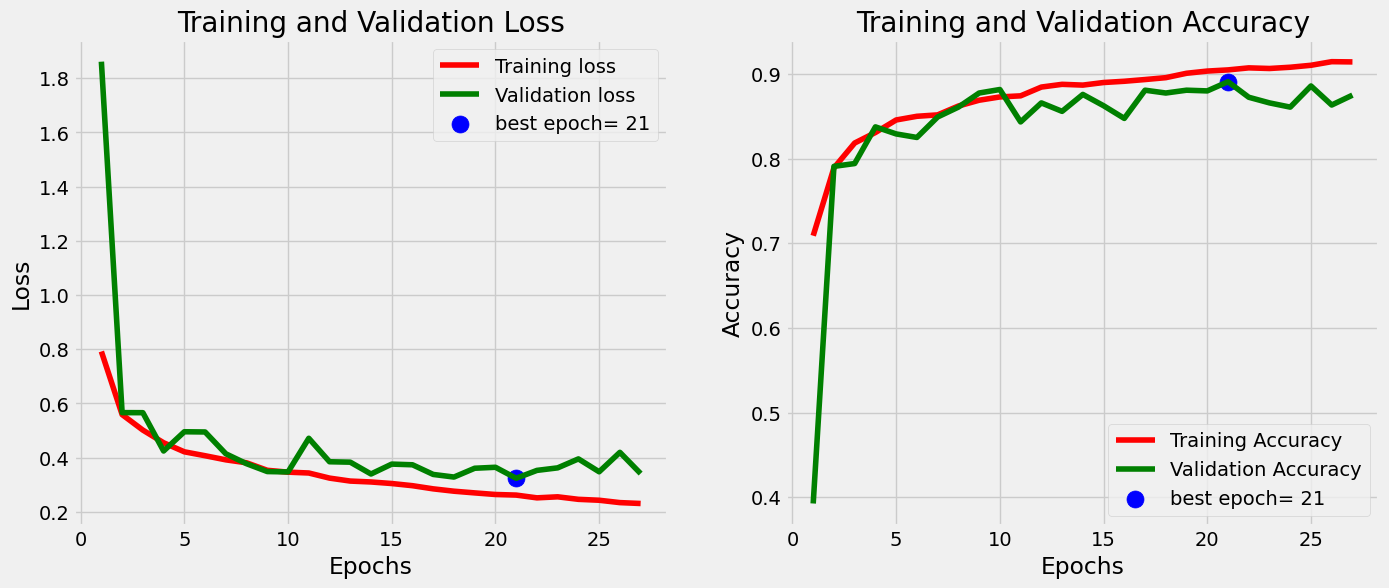

In [ ]:
print("Best model:")
eval = best_model.evaluate(x_test, keras.utils.to_categorical(y_test, num_classes=num_classes))
print (f'Test accuracy: {eval[1]}', f'Test loss: {eval[0]}\n')
plot_history(best_hist)

## Conclusion and Discussion
Through the systematic application of convolutional layers and hyperparameter tuning, we were able to achieve a significant improvement in model performance on the Fashion MNIST dataset. The final best model, identified through hyperparameter tuning with Keras Tuner, achieved a test accuracy of 87%. This is a substantial improvement compared to the initial base models and demonstrates the effectiveness of the techniques employed.

Looking at the confusion matrix, the model performs well across most classes. The misclassifications, such as mistaking T-shirts/Tops or Pullovers for Shirts, are understandable given the visual similarities between these apparel items. The visualization of mislabeled samples further illustrates these challenging cases. Overall, the notebook successfully demonstrates an iterative process of model development, leading to a robust and accurate image classification model for the Fashion MNIST dataset.

**⚠ It is worth reminding that we are using only a sample of the original training dataset (20% - 12k observations).**



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


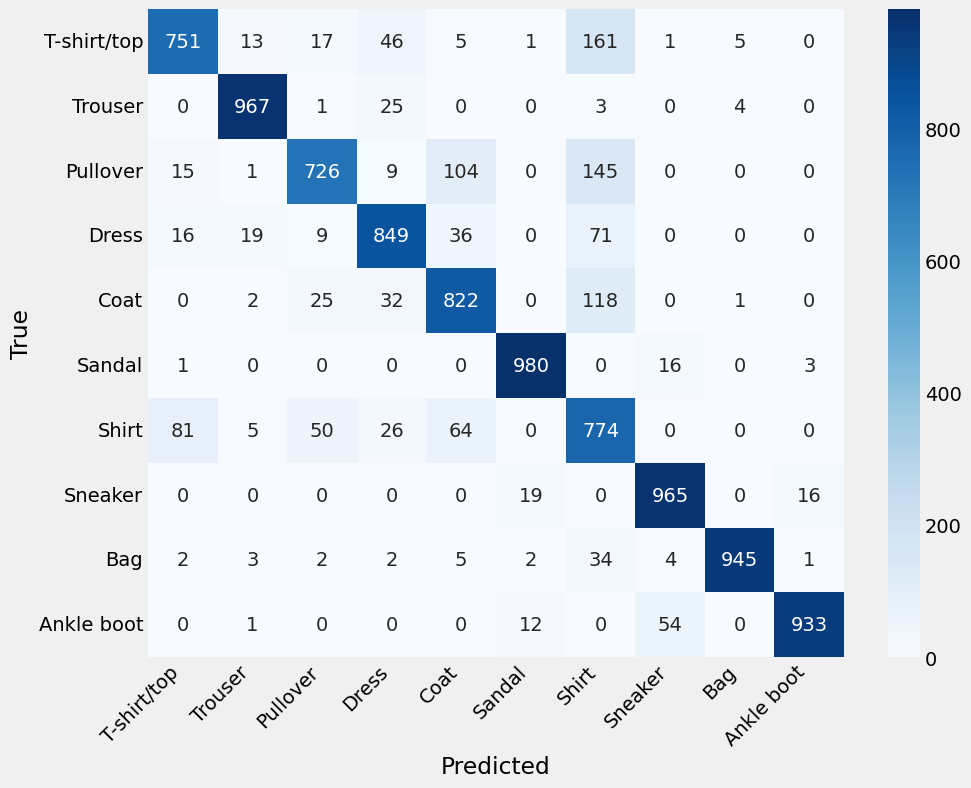

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'];
#building confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#using class labels to replace the prediction_names
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the heatmap with class names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

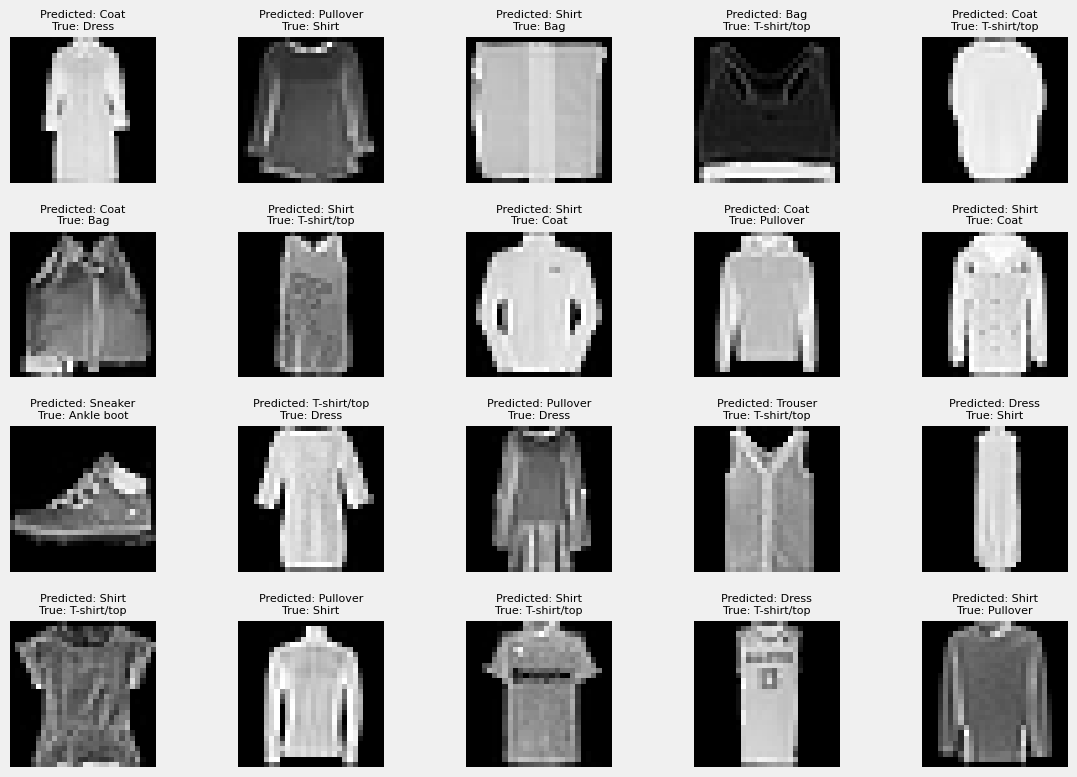

In [ ]:
#showing some wrongly predicted samples
wrong_predictions = np.where(y_pred_classes != y_test)[0]
wrong_20 = np.random.choice(wrong_predictions, size=20, replace=False)

#plotting 20 random wrongly predictions
fig, axes = plt.subplots(4, 5, figsize=(12, 8))
for i, idx in enumerate(wrong_20):
    ax = axes[i // 5, i % 5]
    ax.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"Predicted: {class_names[y_pred_classes[idx]]}\nTrue: {class_names[y_test[idx]]}")
    #smaller title size
    ax.title.set_fontsize(8)
    ax.axis('off')
plt.tight_layout()
plt.show()


### Learnings & Next Steps

This notebook explored various techniques for image classification on the Fashion MNIST dataset, highlighting the significant impact of model architecture and hyperparameter tuning on performance.

Key learnings include:

- **Data Augmentation is Crucial:** While initially appearing to decrease performance on the test set, data augmentation proved vital in reducing overfitting and improving the model's ability to generalize to unseen data, as evidenced by the stabilized validation loss in the augmented model compared to the base model.
- **Regularization (Dropout) Helps Combat Overfitting:** Introducing dropout layers smoothed the validation curves, indicating a reduction in overfitting, even though the initial test accuracy slightly decreased. This reinforces the idea that techniques to prevent the model from becoming too reliant on the training data are important.
- **Convolutional Layers for Feature Extraction:** While simply adding convolutional layers without tuning didn't immediately improve performance and even introduced more variance, they are fundamental for effective image classification. They allow the model to learn hierarchical features from the image data. The initial results with convolutional layers showed the need for further refinement of the architecture and hyperparameters.
- **Hyperparameter Tuning with Keras Tuner is Essential:** Manually experimenting with different architectures and hyperparameters is time-consuming and often suboptimal. Keras Tuner proved to be an invaluable tool for systematically exploring the hyperparameter space and identifying a model configuration that significantly improved performance. The best performing model, discovered through tuning, incorporated multiple convolutional layers, batch normalization, and an optimized learning rate, achieving a test accuracy of 87%.

Based on the learnings, potential next steps include:

- **Explore More Complex Architectures:** Experiment with deeper CNN architectures, potentially incorporating more convolutional and pooling layers, or exploring popular pre-trained models (transfer learning) adapted for Fashion MNIST.
- **Further Hyperparameter Tuning:** Expand the search space for hyperparameter tuning, including exploring different optimizers, learning rate schedules, and regularization techniques (e.g., L1/L2 regularization).
- **Advanced Data Augmentation:** Investigate more advanced data augmentation techniques like CutMix or Mixup to further improve the model's robustness.
- **Cross-validation:** Implement k-fold cross-validation to get a more robust estimate of the model's performance and ensure it generalizes well across different subsets of the data.
- **Visualize Intermediate Layers:** Visualize the output of intermediate convolutional layers to gain a better understanding of the features the model is learning at different stages.

This project demonstrates the iterative nature of building effective machine learning models. Starting with simple baselines, understanding their limitations, and systematically exploring improvements through architectural changes, regularization, and hyperparameter tuning using tools like Keras Tuner are key to achieving better performance.